In [1]:
import tensorflow as tf
# GPU memory growth configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

**Dataset details**

The dataset contains two classes - REAL and FAKE.

For REAL, we collected the images from Krizhevsky & Hinton's CIFAR-10 dataset

For the FAKE images, we generated the equivalent of CIFAR-10 with Stable Diffusion version 1.4

There are 100,000 images for training (50k per class) and 20,000 for testing (10k per class)

# Load the dataset

In [2]:
import numpy as np
import os
import cv2
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

# Define paths to the train and test directories
train_dir_real = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/REAL'
train_dir_fake = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/FAKE'
test_dir_real = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/REAL'
test_dir_fake = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/FAKE'

# Function to load images and labels
def load_images_and_labels(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (32, 32)) 
        images.append(img)
        labels.append(label)
    return images, labels

# Load REAL train images and labels
real_train_images, real_train_labels = load_images_and_labels(train_dir_real, label=0)

# Load FAKE train images and labels
fake_train_images, fake_train_labels = load_images_and_labels(train_dir_fake, label=1)

# Load REAL test images and labels
real_test_images, real_test_labels = load_images_and_labels(test_dir_real, label=0)

# Load FAKE test images and labels
fake_test_images, fake_test_labels = load_images_and_labels(test_dir_fake, label=1)

# Concatenate REAL and FAKE train/test data and labels
X_train = np.concatenate((real_train_images, fake_train_images), axis=0)
y_train = np.concatenate((real_train_labels, fake_train_labels), axis=0)
X_test = np.concatenate((real_test_images, fake_test_images), axis=0)
y_test = np.concatenate((real_test_labels, fake_test_labels), axis=0)

# Convert labels to one-hot encoding
y_train = np.eye(2)[y_train]
y_test = np.eye(2)[y_test]

# Normalize image data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Create an instance of ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the ImageDataGenerator on the training data
datagen.fit(X_train)

# 1. Checking dataset for images and labels


In [4]:
print("Total number of REAL images in y_train:", np.sum(y_train[:, 0]))
print("Total number of FAKE images in y_train:", np.sum(y_train[:, 1]))

print("Number of REAL images in the first 50000 samples:", np.sum(y_train[:50000, 0]))
print("Number of FAKE images in the first 50000 samples:", np.sum(y_train[:50000, 1]))

print("Number of REAL images in the second 50000 samples:", np.sum(y_train[50000:, 0]))
print("Number of FAKE images in the second 50000 samples:", np.sum(y_train[50000:, 1]))

Total number of REAL images in y_train: 50000.0
Total number of FAKE images in y_train: 50000.0
Number of REAL images in the first 50000 samples: 50000.0
Number of FAKE images in the first 50000 samples: 0.0
Number of REAL images in the second 50000 samples: 0.0
Number of FAKE images in the second 50000 samples: 50000.0


In [5]:
print("Total number of REAL images in y_test:", np.sum(y_test[:, 0]))
print("Total number of FAKE images in y_test:", np.sum(y_test[:, 1]))

print("Number of REAL images in the first 10000 samples:", np.sum(y_test[:10000, 0]))
print("Number of FAKE images in the first 10000 samples:", np.sum(y_test[:10000, 1]))

print("Number of REAL images in the second 10000 samples:", np.sum(y_test[10000:, 0]))
print("Number of FAKE images in the second 10000 samples:", np.sum(y_test[10000:, 1]))

Total number of REAL images in y_test: 10000.0
Total number of FAKE images in y_test: 10000.0
Number of REAL images in the first 10000 samples: 10000.0
Number of FAKE images in the first 10000 samples: 0.0
Number of REAL images in the second 10000 samples: 0.0
Number of FAKE images in the second 10000 samples: 10000.0


In [6]:
y_test[9999][0]

1.0

In [7]:
y_test[10000][0]

0.0

# Randomizing the order of data in training and testing datasets

In [8]:
# Shuffle the order of REAL and FAKE train data
shuffled_indices_train = np.arange(X_train.shape[0])
np.random.shuffle(shuffled_indices_train)

# Use the same set of shuffled indices for both images and labels
X_train = X_train[shuffled_indices_train]
y_train = y_train[shuffled_indices_train]

# Shuffle the order of REAL and FAKE test data
shuffled_indices_test = np.arange(X_test.shape[0])
np.random.shuffle(shuffled_indices_test)

# Use the same set of shuffled indices for both images and labels
X_test = X_test[shuffled_indices_test]
y_test = y_test[shuffled_indices_test]

# 2. Checking dataset for images and labels

In [9]:
print("Total number of REAL images in y_test:", np.sum(y_test[:, 0]))
print("Total number of FAKE images in y_test:", np.sum(y_test[:, 1]))

print("Number of REAL images in the first 10000 samples:", np.sum(y_test[:10000, 0]))
print("Number of FAKE images in the first 10000 samples:", np.sum(y_test[:10000, 1]))

print("Number of REAL images in the second 10000 samples:", np.sum(y_test[10000:, 0]))
print("Number of FAKE images in the second 10000 samples:", np.sum(y_test[10000:, 1]))

Total number of REAL images in y_test: 10000.0
Total number of FAKE images in y_test: 10000.0
Number of REAL images in the first 10000 samples: 5016.0
Number of FAKE images in the first 10000 samples: 4984.0
Number of REAL images in the second 10000 samples: 4984.0
Number of FAKE images in the second 10000 samples: 5016.0


In [10]:
print("Total number of REAL images in y_train:", np.sum(y_train[:, 0]))
print("Total number of FAKE images in y_train:", np.sum(y_train[:, 1]))

print("Number of REAL images in the first 50000 samples:", np.sum(y_train[:50000, 0]))
print("Number of FAKE images in the first 50000 samples:", np.sum(y_train[:50000, 1]))

print("Number of REAL images in the second 50000 samples:", np.sum(y_train[50000:, 0]))
print("Number of FAKE images in the second 50000 samples:", np.sum(y_train[50000:, 1]))


Total number of REAL images in y_train: 50000.0
Total number of FAKE images in y_train: 50000.0
Number of REAL images in the first 50000 samples: 25066.0
Number of FAKE images in the first 50000 samples: 24934.0
Number of REAL images in the second 50000 samples: 24934.0
Number of FAKE images in the second 50000 samples: 25066.0


# Build the CNN model

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

In [12]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

In [14]:

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=100)

Epoch 1/15
1000/1000 [==============================] - 369s 366ms/step - loss: 0.2746 - accuracy: 0.8859 - val_loss: 0.2128 - val_accuracy: 0.9185
Epoch 2/15
1000/1000 [==============================] - 365s 365ms/step - loss: 0.1721 - accuracy: 0.9339 - val_loss: 0.2165 - val_accuracy: 0.9125
Epoch 3/15
1000/1000 [==============================] - 364s 364ms/step - loss: 0.1501 - accuracy: 0.9418 - val_loss: 0.2127 - val_accuracy: 0.9233
Epoch 4/15
1000/1000 [==============================] - 364s 364ms/step - loss: 0.1354 - accuracy: 0.9477 - val_loss: 0.4539 - val_accuracy: 0.8687
Epoch 5/15
1000/1000 [==============================] - 362s 362ms/step - loss: 0.1261 - accuracy: 0.9518 - val_loss: 0.1553 - val_accuracy: 0.9416
Epoch 6/15
1000/1000 [==============================] - 366s 366ms/step - loss: 0.1156 - accuracy: 0.9558 - val_loss: 0.1245 - val_accuracy: 0.9535
Epoch 7/15
1000/1000 [==============================] - 365s 365ms/step - loss: 0.1103 - accuracy: 0.9577 - val_

In [30]:
model.save('./models/best_weights.h5')


<Axes: >

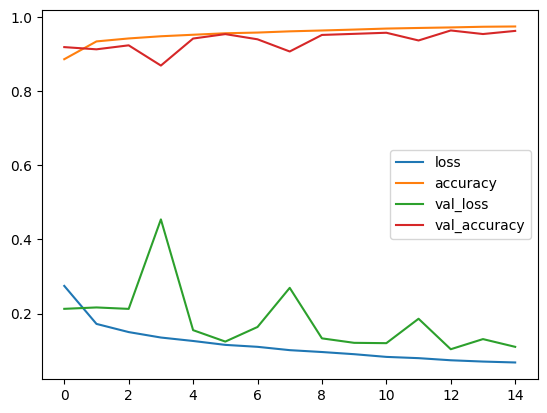

In [31]:
import pandas as pd
pd.DataFrame(history.history).plot()

625/625 [==============================] - 19s 30ms/step


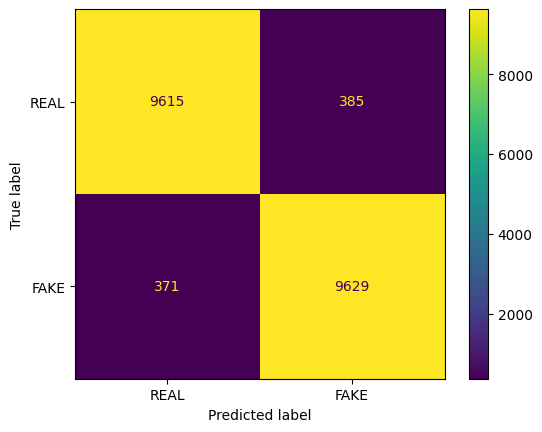

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predictions on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes, labels=[0, 1])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["REAL", "FAKE"])
disp.plot(cmap='viridis', values_format='d')
plt.show()


In [33]:
from sklearn.metrics import classification_report

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=["REAL", "FAKE"]))


              precision    recall  f1-score   support

        REAL       0.96      0.96      0.96     10000
        FAKE       0.96      0.96      0.96     10000

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000



625/625 [==============================] - 19s 31ms/step
Sample Order:
[0 1 1 1 1 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0]
Predictions Order:
[0 1 1 0 1 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0]


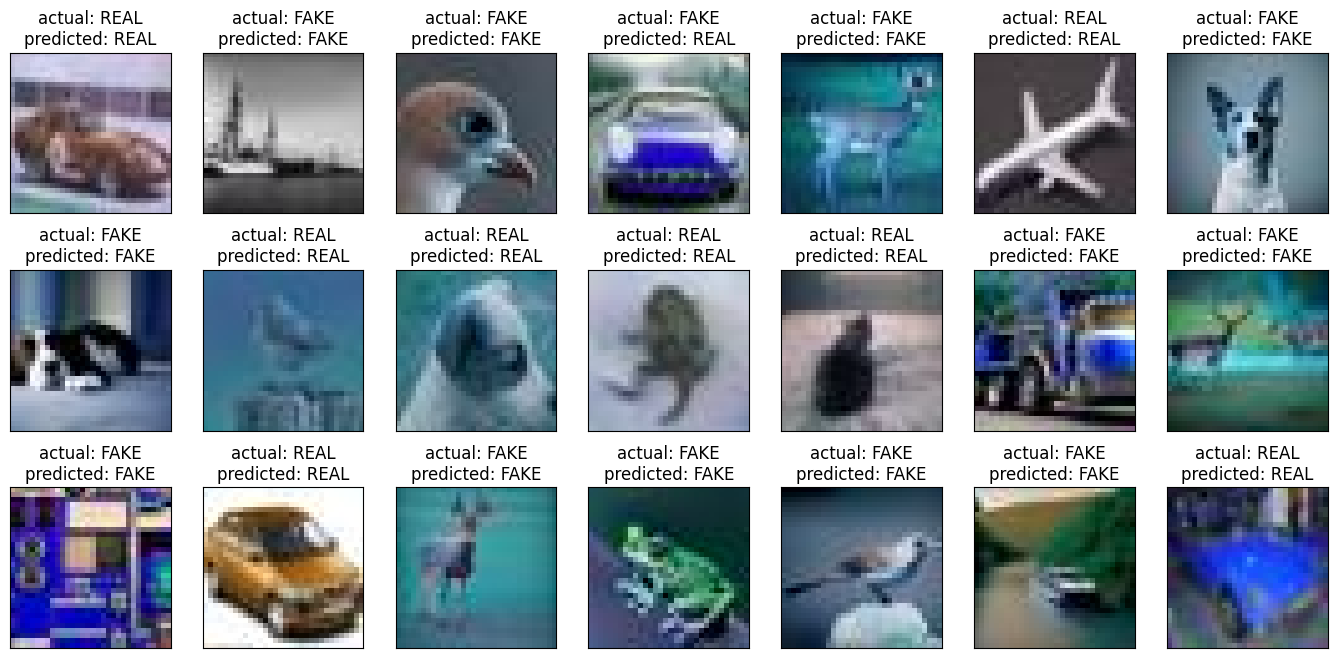

In [35]:
predictions = model.predict(X_test)
labels = ["REAL", "FAKE"]

fig, axes = plt.subplots(ncols=7, nrows=3, sharex=False,
    sharey=True, figsize=(17, 8))
index = 0
for i in range(3):
    for j in range(7):
        actual_label = labels[np.argmax(y_test[index])]
        predicted_label = labels[np.argmax(predictions[index])]
        axes[i, j].set_title(f'actual: {actual_label}\npredicted: {predicted_label}')
        axes[i, j].imshow(X_test[index], cmap='gray')
        axes[i, j].get_xaxis().set_visible(False)
        axes[i, j].get_yaxis().set_visible(False)
        index += 1

# Add debug information
print("Sample Order:")
print(np.argmax(y_test[:21], axis=1))
print("Predictions Order:")
print(np.argmax(predictions[:21], axis=1))

plt.show()


In [36]:
predictions = model.predict(X_test)
for i in range(10):
    actual_label = labels[np.argmax(y_test[i])]
    predicted_label = labels[np.argmax(predictions[i])]
    print(f'Sample {i + 1} - Actual: {actual_label}, Predicted: {predicted_label}')

625/625 [==============================] - 19s 31ms/step
Sample 1 - Actual: REAL, Predicted: REAL
Sample 2 - Actual: FAKE, Predicted: FAKE
Sample 3 - Actual: FAKE, Predicted: FAKE
Sample 4 - Actual: FAKE, Predicted: REAL
Sample 5 - Actual: FAKE, Predicted: FAKE
Sample 6 - Actual: REAL, Predicted: REAL
Sample 7 - Actual: FAKE, Predicted: FAKE
Sample 8 - Actual: FAKE, Predicted: FAKE
Sample 9 - Actual: REAL, Predicted: REAL
Sample 10 - Actual: REAL, Predicted: REAL


In [49]:
from sklearn.metrics import precision_score, recall_score
eval_val_result = model.evaluate(X_test, y_test, batch_size=100)
val_loss, val_accuracy = eval_val_result
print('Validation Loss: {:.3f}'.format(val_loss))
print('Validation Accuracy: {:.3f}'.format(val_accuracy))

200/200 [==============================] - 17s 84ms/step - loss: 0.1103 - accuracy: 0.9622
Validation Loss: 0.110
Validation Accuracy: 0.962
